In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt

from model3 import *
from utils3 import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 106970831.47it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25299852.51it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26902441.71it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6055476.40it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


torch.Size([128, 1, 28, 28])
torch.Size([128])


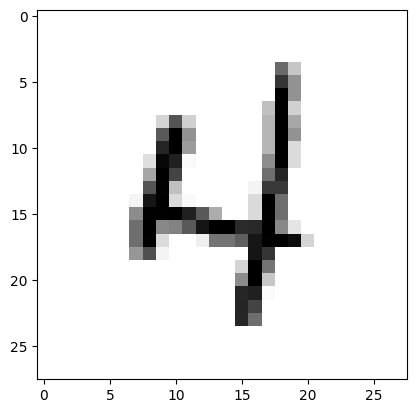

In [ ]:
return_single_image(train_loader)

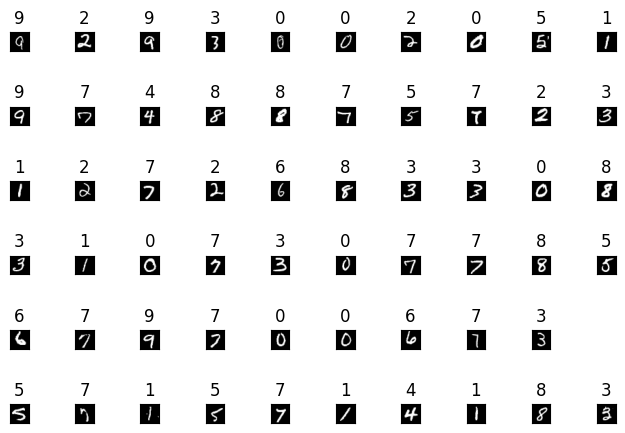

In [ ]:
return_dataset_images(train_loader,60)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [-1, 1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.5789754390716553 Batch_id=468 Accuracy=43.56: 100%|██████████| 469/469 [00:22<00:00, 21.32it/s]



Test set: Average loss: 0.3133, Accuracy: 9056/10000 (90.56%)

EPOCH: 2


Loss=0.10724789649248123 Batch_id=468 Accuracy=93.96: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]



Test set: Average loss: 0.0946, Accuracy: 9689/10000 (96.89%)

EPOCH: 3


Loss=0.16648344695568085 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]



Test set: Average loss: 0.0802, Accuracy: 9757/10000 (97.57%)

EPOCH: 4


Loss=0.057562205940485 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]



Test set: Average loss: 0.0592, Accuracy: 9812/10000 (98.12%)

EPOCH: 5


Loss=0.04871520772576332 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]



Test set: Average loss: 0.0517, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


Loss=0.07156942039728165 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]



Test set: Average loss: 0.0523, Accuracy: 9836/10000 (98.36%)

EPOCH: 7


Loss=0.07418376952409744 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]



Test set: Average loss: 0.0439, Accuracy: 9864/10000 (98.64%)

EPOCH: 8


Loss=0.04485971853137016 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0480, Accuracy: 9841/10000 (98.41%)

EPOCH: 9


Loss=0.003958432003855705 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]



Test set: Average loss: 0.0435, Accuracy: 9856/10000 (98.56%)

EPOCH: 10


Loss=0.03563946485519409 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]



Test set: Average loss: 0.0387, Accuracy: 9869/10000 (98.69%)

EPOCH: 11


Loss=0.03045257180929184 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.0408, Accuracy: 9874/10000 (98.74%)

EPOCH: 12


Loss=0.019572637975215912 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0398, Accuracy: 9876/10000 (98.76%)

EPOCH: 13


Loss=0.10903788357973099 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]



Test set: Average loss: 0.0400, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.0080150431022048 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0368, Accuracy: 9881/10000 (98.81%)

EPOCH: 15


Loss=0.008641487918794155 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0386, Accuracy: 9885/10000 (98.85%)



In [ ]:
train_losses

[tensor(2.3022, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3024, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3021, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3019, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

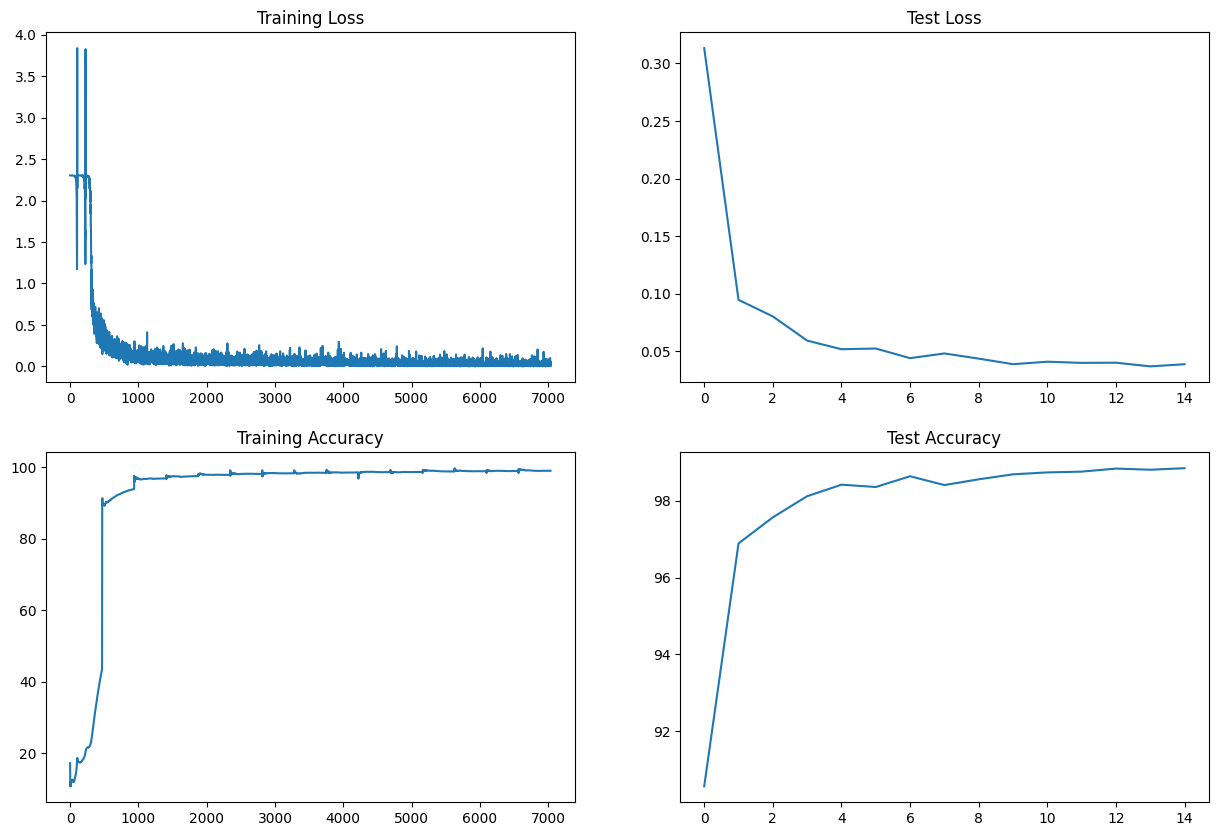

In [ ]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)